In [2]:
import numpy as np
import pprint

np.random.seed(1001)

import os
import shutil

import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.cross_validation import StratifiedKFold  #Deprecated

% matplotlib inline
matplotlib.style.use('ggplot')


In [4]:
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/sample_submission.csv")

In [5]:
train.head()

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>fname</th>
      <th>label</th>
      <th>manually_verified</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>00044347.wav</td>
      <td>Hi-hat</td>
      <td>0</td>
    </tr>
    <tr>
      <th>1</th>
      <td>001ca53d.wav</td>
      <td>Saxophone</td>
      <td>1</td>
    </tr>
    <tr>
      <th>2</th>
      <td>002d256b.wav</td>
      <td>Trumpet</td>
      <td>0</td>
    </tr>
    <tr>
      <th>3</th>
      <td>0033e230.wav</td>
      <td>Glockenspiel</td>
      <td>1</td>
    </tr>
    <tr>
      <th>4</th>
      <td>00353774.wav</td>
      <td>Cello</td>
      <td>1</td>
    </tr>
  </tbody>
</table>
</div>

In [6]:
print("Number of training examples=", train.shape[0], "  Number of classes=", len(train.label.unique()))

Number of training examples= 9473   Number of classes= 41


In [14]:
for label in train.label.unique():
    print(label + " ")


Hi-hat 
Saxophone 
Trumpet 
Glockenspiel 
Cello 
Knock 
Gunshot_or_gunfire 
Clarinet 
Computer_keyboard 
Keys_jangling 
Snare_drum 
Writing 
Laughter 
Tearing 
Fart 
Oboe 
Flute 
Cough 
Telephone 
Bark 
Chime 
Bass_drum 
Bus 
Squeak 
Scissors 
Harmonica 
Gong 
Microwave_oven 
Burping_or_eructation 
Double_bass 
Shatter 
Fireworks 
Tambourine 
Cowbell 
Electric_piano 
Meow 
Drawer_open_or_close 
Applause 
Acoustic_guitar 
Violin_or_fiddle 
Finger_snapping 


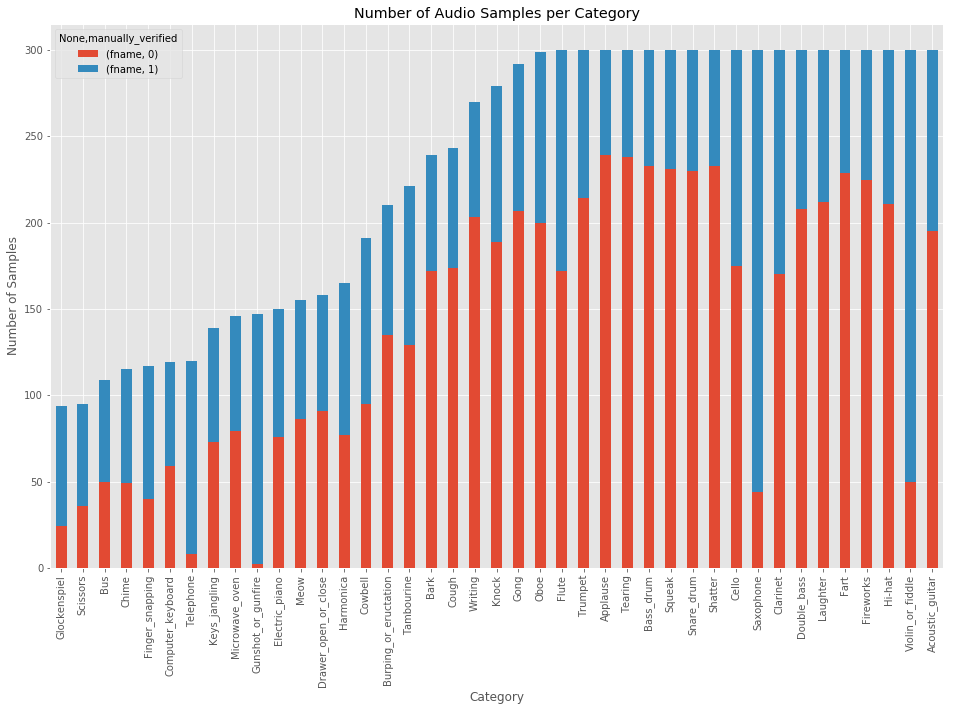

In [16]:
category_group = train.groupby(['label', 'manually_verified']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index) \
    .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16, 10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples")


In [17]:
print('Minimum samples per category = ', min(train.label.value_counts()))
print('Maximum samples per category = ', max(train.label.value_counts()))

Minimum samples per category =  94
Maximum samples per category =  300


In [18]:
import IPython.display as ipd  # To play sound in the notebook
fname = './input/audio_train/' + '00044347.wav'   # Hi-hat
ipd.Audio(fname)

<audio controls="controls" >
                    <source src="data:audio/x-wav;base64,UklGRpTXEgBXQVZFZm10IBAAAAABAAEARKwAAIhYAQACABAAZGF0YXDXEgAAABoA+//0//j/8P/i//f/AwARAEMAjAC5AK4AlgBtAEgAEgDX/6P/lP+s/9j/1/+f/37/lf/c/0kAmwCNAGYAYgCFAIgAPQDq/9z/+//+//b/8f8HABUAPQBwAFsARQAcANj/5/8VAMv/Uf9N/3//Qf9M/9z/zv91/6T/IQA8AP3/8f8GAB4AHADl/23/1v8UAO//kv96AJMA5QCY/7D/gv0uAOL/oAYVB38B7f/19/vvV9rqBK4tBg4L7qvwWgAhAKHw5+qL7rL9QAmbBKnx1Or/AesJgfUb83QGFw9rD0UUswkN54bnrAPJCHkMExBs/SL+tgfrAhH45/nRAg4HMwx3BkEEvAcdAFH+kwwPFpYfuhvjCcsFOQH57b7wEgEVEdoIeQQ6Cwbz8OOF+EoA2QLIB6cTBxGcAEICFRFDFuoAmepr+XUCqe8v7h/p1OtvDTELSe+L+0T8+ezP+w39MvKx8+zvZfL6AWf+QOfi5mP7g/sa+qj6GPFc+18SAxrPBqXqjeBr8WEEnQ1f/sD0MAK2EcwQcg7ZIaISygPcE/QJ+ACNA4UBP/xPBtoF0P3jAJUJxQiKBnUMFBFFAIPtEQsDGyH6QPChC8MF6wP6DEz5hPS8C7YNTwI/HJcNiebD4Fb3O/1T6dfjCusn9toD9BSoE9sDV+vk3XgE6hyA9Y/clAWCEPnnuPDtASDsZfHCAx35xPuUBin0IO6tAXr5jvg+EPcF2O3t7EDiy+0qFmgUPRLQIQARGQOuCNH3iO+wDwkhBRMvEosWkgOYBKoeXhaiCIcSYBHwC+QNUQDkAtQSSApyAm0P8Qc5+EkA9hObGHcAHO54/xQQ+vbT7qLroPGQBpgCUgV6Cwbw5uP861HwjgYTBTT48f4l6mfW7uRo6kfcsOLI7GvtH/YW/eLtEdqQ5h3w0uLB64P/CvlY7hTsOfXS+nXt8Pm7ER0MXvuB7mn0HA7oFf8NFwSN/OwBUA3uBO3v/vjNHrE3+S2eIsEcBxJ2Jkkvow2TFoM63j/FJ08ZcCv3Mg0SMAy9E9X7O/hJDowU+gno87rgufbtElUCaP32DAQHTvlj7T/0gv7/6SPuUxOYDiDaPs/j47v3/fs/7RPfNu/p9Q/ZVs715DDt4d8M8ZPzpdD7yY/snPiJ6bbkS+W74X3b0diO0ufOXef58r3Zrd3r7/bpn+5ICD0KMgSlEj8SjQ88FGUPXiF7MQsrESr6JIQcrSrINdsa+hr5PSdF8S39HCMVFwgGEPIo4xqSBSEalRnWEkgRk/Fm4Ib6BhlSEBn97RG8FKT2JPjSAU79evId+awGfg3jAMbyPvuNE4wJNPcu+lAHlSZ9GcX4nQI6AAb3v/ll//v0kuQF53rsVfjQ81nastV44i3X3r3ZvLfDeN3c4m3ZcsvH0HHgEeI25PHpOut1/nEHY/DI18TjZAY8CdbuUeOf5DL74Q/s+zX2bBdLJF8etyd5H6P2bPAnF0ohTxgGEv0dKTgkMLghICZtOj08GiDhD7kGygd8Fr8XihgCE8/8E+73GXc+Az5rNiAoVDi2Ny4xXCxoLto4fx+h+/Xsc+n2/OMQYCHVFtTyxgE7COTPisyd8ZrW3r446FX/HNIZuFDP9eOoz0fGS9LqxfTGhM52wBfCOMEywgXB6MLzwVDDBsPH1HPv7AEd5Drmeyrf/tAW1DvV5W3FFRMYEFjKGNLQKso+VihkBqwPXRVYDj0tgyWBC0jy+hOv+gvkBC5AOq0MQBRwOVw4Exj8H7o+WDwnPnw4wxxEJT4q3x3vFmoV5A4zMho/typZHOgdWyLCKjoTageU+hnzJ+xb4p/9EwcDA/j9wQUf+tXyahH9HksLTgdO2EHCtMOGvW8Aziq45li5itKq4XfAIsDpywvjHumF5IjGE8f12lfNKvNy/ezZpw/XGgjGsNeBKzUCP8OY9JAgnwiE5R/kEPDJ4+fe3A27FoTzDf10FjfbU8J7BW0FoekPE4obMg+WKGIe2ShhFy/rmS1+Pno/wDIeKiI4fS2QLSMnPRMfAAcwmjxfFPEFegSeLJw+IDdFEQ8vEj5wI+oFctAQyZbrYv6W/G/+WvTM4UHzR/Exyyq8CNBKz1DAJL911WTuj81hzX0MXyR17Me+dOwDCBUBfgTNzn3NJvFezrDAKOWJBurm0+Pc8e7qfusMAUEC2/LBGtgN1uCLI/wpnhYJNf0+/QP3EWQ7pv9zzdvt0hDl/ibyHCQmFsccPERjEiMP5UR6B/EgZUFFPG1AOToYH6cjHhhF/rwG+iTlPrQuxPvf+mb+zuKY7jQCbvxA4mfWbtN01S7j0d+A3af2hPif5W7XtuEg4BTcE/9X2sS9TdRzzY2/csHS03zPLL025/D7I9R38oT5IPjxH4YZ0/Ah5bIojDi66VDfrh4EEAPgNw64KeQ4AUBKIH3wK+e8A3D8hQH7G+MbISYN/df8qgv2E6AtQT+IOP8iazf8ImMTyzNMRPsNMOQpITM1zRkFBwvzABA7QasQ+96yBjMcl+qnytr0dzOiOUD7i+iKBqn7s9W+ugLJYs27vebckQSj66rN+dJi4//Tv7/Q3B/reuqE9pv7qePD7E7m2NoaEI0FUehu8e3lEN0DBaELJ+uV9XwYlTIsCWv2MvZ+6CD1CgnAG9EeewbMAcMtgylh9Sj4TBpD/kHY+w9+NZHem9hvMBAQOOER5+n8NBI2MYQY2xsIQHQwdRP5N3A5xxgCGJEl3C/BIDM0Ryx97TkPLCdf+nwQDyXa21TdGQzK+PMBIQ2g/LYakRAmzu64r9Tx32DQ5hwGJeHySPG19a/V69Bw1SDKUNHl5878r/oIBobufNbZ35ThHgO5Dirh//xqLXMISMupxgfiW+q79HUDdN9tw7jfweLB7p8Z1SZrJbMxOwBbxfrLRv+ACifzag7KG94SJTROFAcBEDrdOFgTpyIWK2kQiBs3NgM+QiwGPJ4yxv6rDLgvuBuxC58lqi+LKq0MIO01/P8De+cn9d0DsOj38Fz9KPer/A4SPAT/6lcU+hXryQzNPhlPB9HkWQ+ND4jWJNHE/sMHLutjzFH1gxcL+OXgaQBP7N6/fcSB98nnmsiWAFgZ8fk+DvoRw/Ce7BHtGtd75sYc2vA0umfV6/gR5K4Izw13zdLTW/WY8Uv09QwLOrMn/xkIKS/3buReHts+Uj+NLcIQShzXNYsQJ+9aF2MTROzJ9kz53+ZyAK0V+yC0D0YB2QXx/JoIPQQe9hAcjgs65a4NVhCy+IsbxyFBCusSqAjBAV0Okx1kEmoLxSs3L/n5ROMu5Ov9qhYl/rIBKxwrBE/P9wC/MkH5dcPs0/b4wd9Xt7DoqA140FvDuuiv3kfRxOhK7ckHKwvW0Te/0+EH7+HE4fF7EQ0DigLjEKb+nO0R6UnmDxGlHJn32AgwCWv15weyFwYsvCz5OGI8+xqxGrAmZBJk/GoNrxUyEnocff4q3JbwkPdfHc4rBQC7Gu4m+P3CFgQZP+fI92cmPiBAHTYTF/ifAqYoyhaf9jsEyBuG5/TH8uCq5B7fI/nD/PXzkf4G2m28ldzu8IbgNQnd+DffCgncD8DYWb1bw17mcPDL0tHWi/kq+DLXIQP6G57pQ9Vp7+79mPMu8yAknh+77wUhWChu7ZP97SGeJFkc5iBIN2Uw2ftS+QEgHjE4LwEFh9tP/2gsXwTX+sEp5SRcGRQemxLd8iXk9urk7nzyoQEZFBMQsQWGFJwJEeEa0VLcH/29ClcBFRP0HD0DkOHH7nYX4fAX2TwXMCa27WrTZ90r8DLr2wPvFvztoM834KzdYMpJ35X2nAEoGGP7wOJ7/TL9bO038ODlzxANOVoHeAaBG/0F/O

In [19]:
import wave
wav = wave.open(fname)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  617400
Duration =  14.0


In [20]:
from scipy.io import wavfile
rate, data = wavfile.read(fname)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (617400,)
[ 0 26 -5 ...  1  0  0]


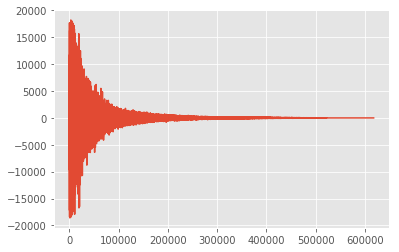

In [21]:
plt.plot(data, '-', )

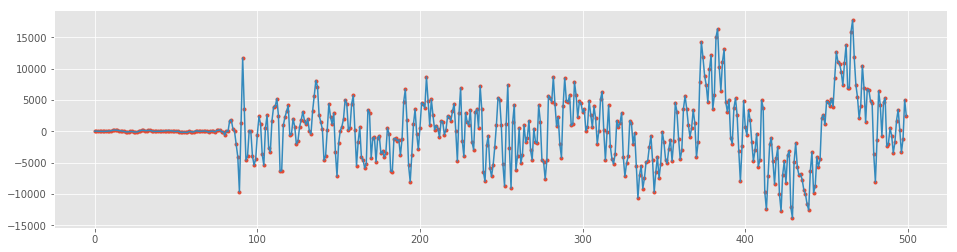

In [23]:
plt.figure(figsize=(16, 4))
plt.plot(data[:500], '.') 
plt.plot(data[:500], '-')

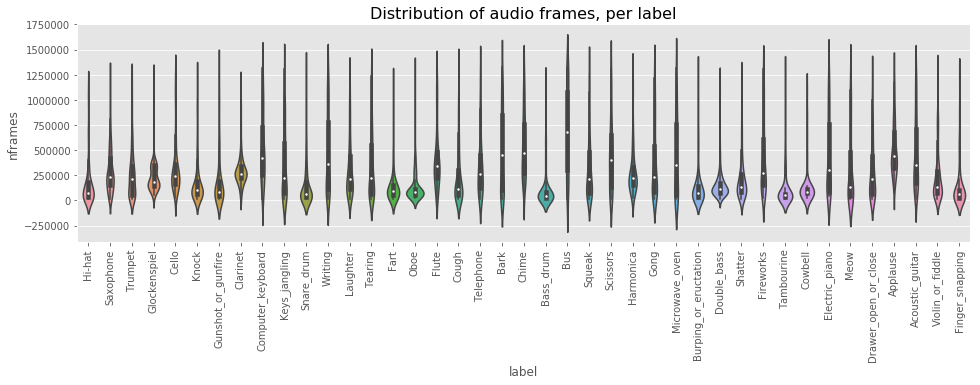

In [25]:
train['nframes'] = train['fname'].apply(lambda f: wave.open('./input/audio_train/' + f).getnframes())
test['nframes'] = test['fname'].apply(lambda f: wave.open('./input/audio_test/' + f).getnframes())

_, ax = plt.subplots(figsize=(16, 4))
sns.violinplot(ax=ax, x="label", y="nframes", data=train)
plt.xticks(rotation=90)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()

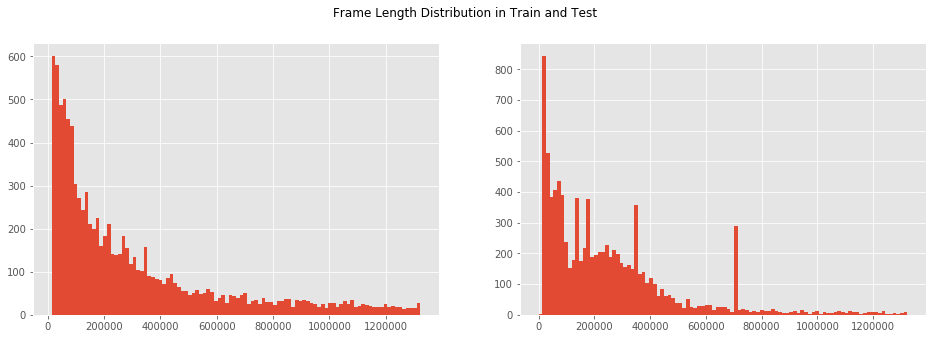

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
train.nframes.hist(bins=100, ax=axes[0])
test.nframes.hist(bins=100, ax=axes[1])
plt.suptitle('Frame Length Distribution in Train and Test', ha='center', fontsize='large');


In [28]:
abnormal_length = [707364, 353682, 138474, 184338]

for length in abnormal_length:
    abnormal_fnames = test.loc[test.nframes == length, 'fname'].values
    print("Frame length = ", length, " Number of files = ", abnormal_fnames.shape[0], end="   ")
    fname = np.random.choice(abnormal_fnames)
    print("Playing ", fname)
    IPython.display.display(ipd.Audio( './input/audio_test/' + fname))


Frame length =  707364  Number of files =  210   Playing  a9de7384.wav


<audio controls="controls" >
                    <source src="data:audio/x-wav;base64,UklGRmyWFQBXQVZFZm10IBAAAAABAAEARKwAAIhYAQACABAAZGF0YUiWFQD+//z//////wEAAAABAP//AQD//wAA/v/+/wAA//////7/AAD//wEA/v8AAAEAAAAAAP7//v/9/wAA//8BAAAAAAABAAIAAwAAAAAA//8BAAAAAAD///7/AQD+/wAAAQD///7/AQD+/////v8AAP////8BAAEAAAD//wAA//8AAAAAAAAAAP////8AAP//AQD/////AAAAAP///v///wIAAQD/////AAAAAP///////wAA/v////3/AAAAAP7/AQD///7/AQD/////AAD//wAA//8AAAAA/v8AAP//AAD+////AQD///3////+/wAA/v8BAP//AgAAAP//AQD+////AAAAAP//AAD//wAA//8BAP3/AAD/////AAAAAAAA/v///wAA//////////////3//f8BAP3//v8BAAAA//8AAAAA//////////8AAAAAAAAAAP//AAABAP7/AQAAAAAAAAD/////AAD//wAA//8BAP7/AAAAAP////8AAP7//v8AAAAAAAD/////AAD/////AQAAAP/////+/wEAAAD//wAA//8BAP//AAAAAP7//v8AAP//AQD//wAAAQABAAEA//8BAAAA//8AAAEA///+//////8AAAAAAQD+/////v///wAA/f/+////AAD9//7//v8AAAAA///9/////f8AAAAAAQAAAAIAAQD//wMAAQADAAEA/v//////+//7/////v8AAAEAAAABAAIAAAD+//3//v8DAAEA///9//7//v/6//r//v8EAAAA/////////P///wMAAwAFAAIAAQAHAAIAAQD///3/AwAAAP3//v8AAAUABgAEAAEAAAADAAIAAQD+//7////7////AQD//wAA/f/+//7/+/8CAPz//P/+//j//f/7/wAAAQD8/wIA/P/6//7/9f/+/wUA/v/7//n/+//8////BAAHAAEA//8BAAQAAQABAP///f8AAP/////+//r/+//8//7//v/6//7/9v/4//v/AQADAPv///8CAPv/+/////n/+f/7//r///8EAAIAAwACAPr/+P8CAAYAAAD+//v/+v/5//r//P/8//v/9//4/wEABQABAAEAAQD//wEABAALAA8ABAABAAQA//8BAAoABgD8//n/AwACAPz/AgABAP7//P8AAAUABgD9//X/9//9/wAACAAFAP3/BAAEAAAABwADAAEA/P/6/wIAAQABAAIAAAACAPv/AQD+//n/AAD9//7/AAABAPz//v8BAAIAAwAEAAIA+v8CAAcAAQD8//n/AQADAPj/9f/6/wQAAAD4//3/AAAEAAMABQABAP7/AwAEAP7/AQAEAPj//v////3/AAD9/wEA//8AAAMA+v/6//j//v8BAPv/AAABAPn/BAAIAAcACgAAAPj/+f8CAAgABAD9//z/BAAEAPj/AgADAPP/8v///wkA/f8AAP//+f/9/wgADQAMAAkABQAIAAkABwARABQACQAFAAIABAAHAAMAAAD6//j/+v/+/wsACQD+//n/AwAFAAUADQAOAAQACQD+//7/CAD7//r/CQADAP7/CgAPAAwA///8/wQA/f////3/+v/4//X/9v/1//3////7//n/+P/5/wgAAwD6/wIAEAAQAAsADQAEAPv/9f/8/xUADQD6/wMA8////wIA9f8FAAAABgD///T//P/y//f//v/4//v/9P/8//7/9f8DAP3/+v/7//H/9v/4//T/+//2/+7/9/8IAAsAAAABAPD///8JAPH/9v/v//n/BwD8/wMABAASABYACwD+/wIAAwD2/wUAFgAUAAMA9f/1//3/9//z//3/CgADAPf/7//1/wYABAAGAAYAAgALAA4A+//x//H/6//r//f/+v///wkAAAABAAEAAwANAAkACwD8//v/+v/w//z//f/+/wgA/v/+/wIA9P/2//n////6//H/8//y//D/+P/0/+b/8//+/wMABwD3//v/BwDy/+//+f8FABAA9//3//v/AQD8//r/DQAAAAUA9v/q//7/6//o/wAA/v8CAP//CQAHAOz/8//9//7/BAAGABMAAwD1/wsABAAAAPn/8f8PAAwAAgD9//X/BwACAP7//P8BAAMABQARABIACQAEABEACQD+//n/7v/0/wIADgAOAP//AgD7/+3/9v8DAAQA/v/8//b//f8JAAcACwAKAAkAAQAIAPz/AQD6//H/CQAJAPz/AQABAP//BAD7/+3/7P/4/wAACwAPAPv/+/8FAP//+P/1/+r/8P/6/wIABwD+//f/6P/r/+7/6f/0//L/+P8EAAUA/v/5//T////5/+7/9//v//n//f/u//T/CwAHAAMADAACAP7//f/5/xAAFAD3/w0AEQACAAMA9/8JABwABwAIAP//9//4//L/CAAPAAEA6v/w//X/8P/y//r/9v/g//j/8v/3//z/9P8IAOL/6f/4/wcADQD1/wEAFQAGAAAACAD7/wUA8P/9/wYAAQADAAIAGgACAP3/9v/3/wAA+f8DAAoA9P/7/wIA9P8TAPf///8QAPP/CwAdAAEADwACAPz/EgDw/xAA8v8EAAoA8v8XAPn/GQAHAAQACQD1/wwABwADABEAAAAGABIA7f8UAPT//v8BAPT/EQABAAQA8v8CAPv/CgDh//z/+P/9/x8A5v8KAOn/HwDY/w8A6P8DABIAy/+fALX6O/aH9o/19/Ya99n3bfgE9y/3C/gM+FH3o/hj+fj5aPwv/Dv86v2P/an+dv7D/F/+4//lAPv/gP5X//QAwAEGANj/8AACAQgCfwKeAWgCgANkAqgCOAQaBPcC7wJaAt0BLAOdA1QE8wQQBekEQgVyBtkFWAWpBNoDigMyAxcF3QRbA3oEKwMUAlECzgEoAwEDeAErARAB8QAXAhMDKwIfAw8FwQSyBPAFPgU+BBAEQwT8BDMEUwT6A8sC0gIqA3kDKgN7AvoC8QQtBf4FNgWYAxUE0AMdBccEcAR3BOkDKgTiBKUGBAVrBakFDgRGBYAFKwWKA7cDGQRIA0EEywPqAq8BEQF0AQEBNQEfADT+4/ya+zH95/y5+1L9rvsi/KT9DP3n/fP84ftl+4X8Jfwr+er5RPrK+cf60fvs+zz8cf48/98ACQKJ/5r+TP/M/5r/Vv4t/ob+Mf4m/zgABwC3AN8B4wIZA1cCFQMzBIoD+gGn/9n+2/8u/zL/9v/F/lv+U/9v/zb/PAAHADf+LP3m/Lr8gfxT+8n5zvkm+ID4tPpo+IH3e/au9I/1A/Yc9gP1OPQI8znyavTq9VX2tfU49crzi/Km9ED1FfVD9IXyjPIE88v0y/WL9Yr1yfT49L/20fit+Dv4k/jv96P4qvm/+g770vrr+9X7k/zg/bcAaQPXAh0EYAQdA0ADVgTRBJYDGAK5AJoBngJMBLUEvQPZBJQDTgRxBnoGbQbjBBMD7QFKAgIDnANMA0MCJAIuAUYBxgPYBHQDtgMZAxgCGQTRBOIDbwKQAcYAlwFyA2UDkQMOAjMBKAIfA3sErAXyBcsErwU1BssGKAhvB/0H3QiQCbEJYgnBCKsHoQh8CJkHdAeRB0oIkAiVCDYITwkMCqMIqgfjBzgJBQkWCNcGIQaPB7MGXga4Bo4F6QUABvAErwRFBqAFvAPdA8ECIQJ1AQYANwD6/6z/AgCKAE8A0/6g/8n/OP+U/3T9Yf6A/tr83f6m/RL+qP/m+337AP04+7D6tfqk+mX7o/rY+dz5pviE+Ib6YPt//CX8FPvI+6b6Rvsp/OX9h/+7/jIACwA8AfEBxAAiAbf//v44/xIAU/+T/iD+KP0l/k79J/6h/t39g/90/wn+8Ps4+XH0g/

Frame length =  353682  Number of files =  127   Playing  7a3ddfdd.wav


<audio controls="controls" >
                    <source src="data:audio/x-wav;base64,UklGRkjLCgBXQVZFZm10IBAAAAABAAEARKwAAIhYAQACABAAZGF0YSTLCgD///7//////wEA/////wAA///+//7//////wAAAAAAAAAA/v///wAAAQAAAP///v8AAAAAAAABAAEA/////wEAAAD//wAAAAD+///////9/wAAAAD//wEA/v////////8AAAEA///+/wEAAAAAAAAAAAD//wAA//////7//v//////AAACAP/////////////9//3//f////////8BAP7///////7///8BAP7//v8AAAAAAAD//wEA/v8BAAEAAAAAAAAAAAAAAAEAAAD//////////wAA/////wEA/v8BAP3//v//////AQD///7/AAAAAAEAAAAAAAAAAQACAAAAAAD+//////8BAP////8BAAAA/////wAA//8AAAEAAAD/////AAD//wAA/////wAA/v///wAAAAAAAAAA/v8AAAIAAQD///////8AAP7/AQD//wAAAAD//wAA/f8BAP//AQABAAEAAAD+/////v////////8BAAEA////////AAABAAAA//8AAAAA///+//3///8AAP//AQD//wAAAAD+//7/AAD9//7//f8AAAEA///+/wEAAQD//wAAAAAAAP7//v////////8BAAEAAgD//wAAAAD+/wAA/v///wAAAQAAAAAA/v8AAAEA/v8AAP7//v////////8BAP////8AAP///v///////////wIA//8AAP7/AAD//wAA/////wEAAAAAAAAAAAD//wAA//8BAAEAAQD//wAAAAAAAP//AQAAAAAA///+/wAAAAD///7/AAAAAAAAAAABAP3//v/+/////v///wAA//8AAP///////wAA///+/wAAAAAAAP/////+////AAAAAP///////wAAAQD///3/AQAAAAAAAAAAAP//////////AAABAAEA//8AAAEA//8AAP//AAD+/wEA/f////7///8AAAAA//8AAP////8AAP/////+////AAAAAP//AAD//wAA//8AAAAAAAD+/wAAAAD/////AQD+/wEAAAD+/////v8AAAAA///+/////////wAAAAD//wAA//8AAP7///////3////+//7/AAD/////AAD///7///8AAAAAAAAAAP7/AAABAAEA/////wEAAQD///////8AAP///v////////8AAP//AAD//wAAAAD/////AAABAP7///8AAP//AQAAAP/////+/wEAAAD+//////8BAP//AAAAAP////////7///8CAAAAAQD+/wAAAQD//wEA///+//7/AAD/////AQD//wAA/v/+////AQAAAP//AAAAAAAA/v8BAP////8AAP//AAD9////AAAAAAAAAQD/////AAD//wAA//8AAAAAAAAAAAAA/////////v8BAAAAAAD+/wAAAQD//wAA//8AAAEAAAAAAAAA/////wAAAQD//wAAAQD///////8AAP7/AAAAAAAAAgD9/wAA/v//////AAABAP//AAABAP///v///wAA/////////////wEAAQD////////+////AAAAAAAA/////wAAAQD//wEA///+/wAAAAD+//3/AAABAAEA//8BAP//AAD///7/AAD///7///////////8BAAEAAAD//wEA/////wAAAAD///7/////////AAABAP/////+//3/AAAAAP////8AAP///v8AAAAA/////wIA//////3//v8AAP//AQD///3///8AAAAAAwD+/wAAAQAAAAAA////////AgAAAP///v//////AQD///3/AQD/////AQD+/wAAAAAAAAAA/v////7///8AAP//AAAAAAAA/////wEA//////7/AAAAAAAAAAD//wAA/v8BAAAAAQABAP/////+/wEA/////////////wAA/v8AAP//AAAAAP///v///wAAAAABAAAA///+//7//v/+/wEA//8AAP////8AAAEA//8AAP//AAD//wAA//8AAAAAAQD///7/AAD/////AQD//////v8AAAEAAAAAAAAA/v8AAP7/AAABAAAAAAD+///////+////////////AQD+/////v/9/wEAAAAAAP//AgAAAAEA/v8BAP//////////AAAAAP/////+/wAA/v8BAAAA/v////3///8AAAAAAAABAP//AAD///////8AAAAAAAABAAEA/v//////AAD//wEAAAD+/wMAAQAAAP7/AQABAP7/AAD+/wEAAQAAAAAA/f8AAAAA/v8BAP//AAD/////AAAAAP7/AAD//wAAAQABAAIAAQAAAAAAAAD///7//v/+/wAA//8AAP7/AQAAAAAA//8AAP///v/+/wAA//////7/AQAAAP//AAD////////+/wAAAQACAAEAAQD///3///8BAP///////wAA/v8AAAAA/v8AAAAAAgD+/wEA//8AAAAAAQAAAP//AAD///3/AAD//wAA//8AAAAAAQD+/wAAAgABAAAA//8AAAEAAQD//wAAAAD/////////////AAABAP/////+////AAAAAP//AAAAAAEAAwD+/wAAAAAAAAAAAgD+/wEA///+//7////+//7//v///wAA/v//////AwABAP///v8AAAIAAQD//////v/9/////v///wIAAQABAAAAAQD//wAAAQD///7/AAABAAEAAAABAP//BQAAAP//AAD///r//f///wMACAD+/wAAAAAHAAcAAQD8//X//P8BAPv//v/6//r////5//P/AAD+/wEAAAD8/wEA/f8IAAcAAwABAP3/DQAAAPv////y//r/AQADAAEAAwD+/wcADgAPABAAAwD//wcACwAAAAsABAADAP3//f////3/9v/5//j//f8GAP7//P/+//r////4/wYA/P8BAA0ACAADAPf/AQABAPv/+//0//L/3/8PADkANQBaAHcAvwB+ABIA6P8o/zz+kfws+w76cvnj+aX6V/uS+0r9ZgB/A6wEagOlAcsBFgUdBosCZ/zo+GP70/9XA+YDUAUFAxL/Pv2K/y0HbA9bFQgW/xJpDAMFlwCaAVMGYw/cE/gO6wUz/l8G7xbrIzIjVRFzAHj32vtfCHkRLBDMCCYBFfzG/KsC5whuCUsH5ARRAs//GADnAp8HAwppA1n4Au+h7s71cPymAZj+c/fr85n0Hf3FBe8Ezfx18cjrTO9w+mQCswL1/Fb0X+8u8Oz3mwK9CW4Gxf2E9Rv18/3BBq8LcAhWAAb4BvWi+Z8AQQqBDukI1P5m+HP8AgedET0Vmg+zBjIBIQJaBlANhA4tCYsAyvjj+B3/8Qh5CzMHrgERAMUFRA+VFScWsBJSC+sHMwZmCIkKpAjRAoz5fPgn+uX+bQLFAUIDAQVYB4MHxAadCiIRShZAFqYQoQjKAr8AJgAd/oX4AfGA7Enwk/nPBOALcQpMB8MGGwyhEkkSDQ8JCKUDGQCY+Wr2IfcP+rL3c/CR6dTsFfW//tUF4wjPB50BZQGqAg0IxgqyBNj7b++O6mLr1+1p8sfwH++27EjuHfLr9e79FQJAAz3/zPip9O7zYfic+m34RPSB7BvnnuWw6ifyyfN88y7yTPO++UH/nwEzAk7++vg89aL00vY0+KL3MfXM9Nf0YvaD+wsApgORAzkCdgEOAkkDNwWAB5sH5gYqA7r+r/xEAIsFiAp8DA8LDQmmCAUM1A5IEXgQHg4DC9YHvwXsBVoJ1Q1zEGANAAf+BuwL3RKeGf4VKw1cBSYC2gTtDL0S6w9zCJUB6v/kApkJ6Q+xERwOQgddAq4DoQiZDdkO2gsEBz0Bm/7K/tIBbAbUCPwG7gGi/gr/fg